In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../python/')

import pml
import util

# test 1

+ distribution $p$ uniform on $\{1,...,S\}$
+ vary $n$ (sample size) between $\sqrt{S}$ and $100S$
+ $S$ known case, $S$ unknown case
+ plot vs. $n$:
    + number of clumps in approximate PML distribution
    + inferred support set size (for $S$ unknown case)
    + probability to have "continuous" part in inferred distribution

#### get data

In [10]:
S = 10_000 # support set size
p = np.ones(S)/S # distribution

# iterate over S unknown, known
S_known_list = [False,True]

# make sample size list n_list
n_min = np.sqrt(S)
n_max = 100*S
num_n_points = 21
n_list = np.logspace(np.log10(n_min), np.log10(n_max), num_n_points).astype(int)

num_trials = 100 # number of trials for each value of n

record_num_clumps = {S_known: [[] for n in n_list] for S_known in S_known_list} # num clumps by trial, by n
record_inferred_S = {S_known: [[] for n in n_list] for S_known in S_known_list} # inferred support set size by trial, by n
record_has_continuous_part = {S_known: [[] for n in n_list] for S_known in S_known_list} # true iff inferred distribution has continuous part

for S_known in S_known_list:
    print('S known:',S_known)
    for (i,n) in enumerate(n_list):
        print('n:',n)
        for trial_num in range(num_trials):
            # draw empirical histogram
            hist = util.draw_histogram_from_multinomial(p, n)
            S_empirical = np.count_nonzero(hist)
            # get approximate PML
            if S_known:
                (p_pml, F0, _, _) = pml.PML_distribution_approximate(hist, S, warn_on_continuous_part=False)
            else:
                (p_pml, F0, _, _) = pml.PML_distribution_approximate(hist, warn_on_continuous_part=False)
            # record num clumps
            record_num_clumps[S_known][i].append(np.unique(p_pml).size)
            # record estimated support set size
            if not np.isinf(F0):
                record_inferred_S[S_known][i].append(S_empirical + F0)
            # record whether has continuous part
            record_has_continuous_part[S_known][i].append(np.isinf(F0))

S known: False
n: 100
n: 158
n: 251
n: 398
n: 630
n: 1000
n: 1584
n: 2511
n: 3981
n: 6309
n: 10000
n: 15848
n: 25118
n: 39810
n: 63095
n: 100000
n: 158489
n: 251188
n: 398107
n: 630957
n: 1000000
S known: True
n: 100
n: 158
n: 251
n: 398
n: 630
n: 1000
n: 1584
n: 2511
n: 3981
n: 6309
n: 10000
n: 15848
n: 25118
n: 39810
n: 63095
n: 100000
n: 158489
n: 251188
n: 398107
n: 630957
n: 1000000


#### plot

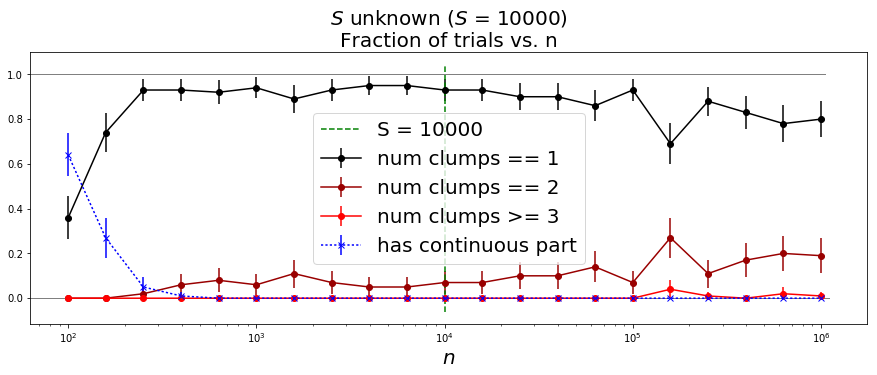

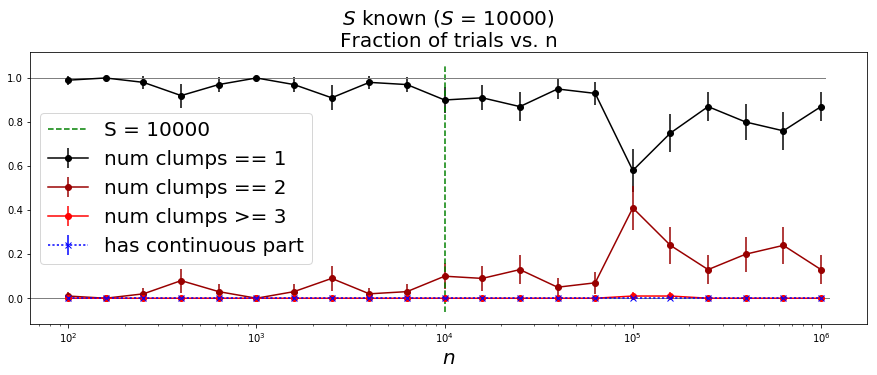

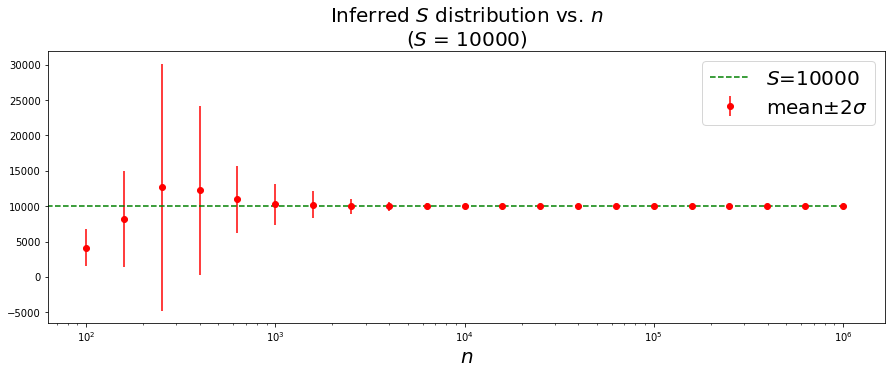

In [13]:
colors_by_num_clumps = {1:[0,0,0], 2:[0.6,0,0], 3:[1,0,0]}

for S_known in S_known_list:

    fig = plt.figure(figsize=(15,5))

    # plot probability to have certain number of clumps
    # case (1,2,>=3)
    for (num_clumps, strict_equal) in zip([1,2,3],[True,True,False]):
        if strict_equal:
            y = np.array([np.sum(np.array(record_num_clumps[S_known][i])==num_clumps)/num_trials for i in range(n_list.size)])
            label = 'num clumps == {}'.format(num_clumps)
        else:
            y = np.array([np.sum(np.array(record_num_clumps[S_known][i])>=num_clumps)/num_trials for i in range(n_list.size)])
            label = 'num clumps >= {}'.format(num_clumps)
        yerr = 2*np.sqrt(y*(1-y)/num_trials)
        plt.errorbar(n_list,y,yerr=yerr,fmt='o-',color=colors_by_num_clumps[num_clumps], label=label)

    # plot fraction of trials that result in approx. PML distribution having continuous part
    y = np.array([np.count_nonzero(np.array(record_has_continuous_part[S_known][i]))/num_trials for i in range(n_list.size)])
    yerr = 2*np.sqrt(y*(1-y)/num_trials)
    plt.errorbar(n_list,y,yerr=yerr,fmt='x:',color=[0,0,1], label='has continuous part')
    
    plt.plot([S, S], plt.gca().get_ylim(), '--', label='S = {}'.format(S), color=[0,0.5,0])
    plt.plot(plt.gca().get_xlim(),[1,1],'-',linewidth=1, color=[0.5,0.5,0.5])
    plt.plot(plt.gca().get_xlim(),[0,0],'-',linewidth=1, color=[0.5,0.5,0.5])

    plt.gca().set_xscale('log')
    plt.legend(fontsize=20)
    plt.title('$S$ {}known ($S$ = {})\nFraction of trials vs. n'.format({True:'',False:'un'}[S_known], S),fontsize=20)
    plt.xlabel('$n$',fontsize=20)

    plt.show()

fig = plt.figure(figsize=(15,5))

# plot mean, standard error of inferred support set size
y = np.array([np.mean(record_inferred_S[False][i]) for i in range(n_list.size)])
yerr = np.array([2*np.std(record_inferred_S[False][i]) for i in range(n_list.size)])

plt.errorbar(n_list, y, yerr=yerr, fmt='ro', label='mean$\pm 2 \sigma$')
plt.plot(plt.gca().get_xlim(),[S,S],'--', label='$S$={}'.format(S),color=[0,0.5,0])

plt.gca().set_xscale('log')
plt.legend(fontsize=20)
plt.title('Inferred $S$ distribution vs. $n$\n($S$ = {})'.format(S),fontsize=20)
plt.xlabel('$n$',fontsize=20)

plt.show()

# test 2

+ distribution $p = (1/S,\ldots,1/S,0,\ldots,0)$, alphabet size $2S$
+ vary $n$ (sample size) between $\sqrt{S}$ and $100S$
+ plot vs. $n$:
    + number of clumps in approximate PML distribution

#### get data

In [14]:
S = 10_000 # support set size
p = np.append(np.ones(S)/S, np.zeros(S)) # distribution

# make sample size list n_list
n_min = np.sqrt(S)
n_max = 100*S
num_n_points = 21
n_list = np.logspace(np.log10(n_min), np.log10(n_max), num_n_points).astype(int)

num_trials = 100 # number of trials for each value of n

record_num_clumps = [[] for n in n_list] # num clumps by trial, by n

for (i,n) in enumerate(n_list):
    print('n:',n)
    for trial_num in range(num_trials):
        # draw empirical histogram
        hist = util.draw_histogram_from_multinomial(p, n)
        S_empirical = np.count_nonzero(hist)
        # get approximate PML
        (p_pml, F0, _, _) = pml.PML_distribution_approximate(hist, 2*S, warn_on_continuous_part=False)
        # record num clumps
        record_num_clumps[i].append(np.unique(p_pml).size)

n: 100
n: 158
n: 251
n: 398
n: 630
n: 1000
n: 1584
n: 2511
n: 3981
n: 6309
n: 10000
n: 15848
n: 25118
n: 39810
n: 63095
n: 100000
n: 158489
n: 251188
n: 398107
n: 630957
n: 1000000


#### plot

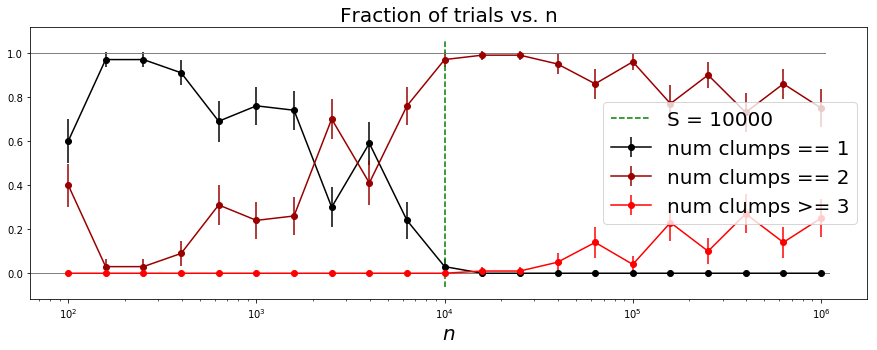

In [16]:
colors_by_num_clumps = {1:[0,0,0], 2:[0.6,0,0], 3:[1,0,0]}

fig = plt.figure(figsize=(15,5))

# plot probability to have certain number of clumps
# case (1,2,>=3)
for (num_clumps, strict_equal) in zip([1,2,3],[True,True,False]):
    if strict_equal:
        y = np.array([np.sum(np.array(record_num_clumps[i])==num_clumps)/num_trials for i in range(n_list.size)])
        label = 'num clumps == {}'.format(num_clumps)
    else:
        y = np.array([np.sum(np.array(record_num_clumps[i])>=num_clumps)/num_trials for i in range(n_list.size)])
        label = 'num clumps >= {}'.format(num_clumps)
    yerr = 2*np.sqrt(y*(1-y)/num_trials)
    plt.errorbar(n_list,y,yerr=yerr,fmt='o-',color=colors_by_num_clumps[num_clumps], label=label)

plt.plot([S, S], plt.gca().get_ylim(), '--', label='S = {}'.format(S), color=[0,0.5,0])
plt.plot(plt.gca().get_xlim(),[1,1],'-',linewidth=1, color=[0.5,0.5,0.5])
plt.plot(plt.gca().get_xlim(),[0,0],'-',linewidth=1, color=[0.5,0.5,0.5])

plt.gca().set_xscale('log')
plt.legend(fontsize=20)
plt.title('Fraction of trials vs. n',fontsize=20)
plt.xlabel('$n$',fontsize=20)

plt.show()